# SP2273 project: How do neurons synchronize to cause a seizure? 

## Importing packages 


In [2]:
import numpy as np
from scipy.integrate import solve_ivp # for solving system of ordinary diff eqns for phase function theta(t)
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 80 # increase memory for animation
import matplotlib.pyplot as plt # to plot graph of r(t) against t
import scienceplots
# Load style first
plt.style.use(['science'])
mpl.rcParams.update({
    'font.family': 'Arial',
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'axes.labelsize': 14,    # x and y axis labels
    'axes.titlesize': 16,    # title
    'xtick.labelsize': 12,   # x tick labels
    'ytick.labelsize': 12,   # y tick labels
    'legend.fontsize': 12    # legend
})
from matplotlib.animation import FuncAnimation # to animation r(t) and theta(t)
from scipy.io import wavfile # to read waveform

## Loading the WAV audio file 

In [7]:
# Loading WAV file
fs, data = wavfile.read(input(f"Enter your .wav file: "))  # fs = sampling rate, data = audio samples

# If stereo, take 1 channel
if len(data.shape)>1:
    data = data[:, 0]

N_samples = len(data) # number of initial samples
t = np.arange(N_samples)/fs

## Computing FFT (Fast Fourier Transform), taking only the 1st half by symmetry


FFT breaks down the signal into frequencies, phases and amplitudes.
It transforms the signal from the time domain (how it changes over time) to the frequency domain (what frequencies it contains)


In [8]:
# Compute FFT, taking only the 1st half by symmetry
fft_result = np.fft.fft(data)
freqs = np.fft.fftfreq(N_samples, 1/fs)[:N_samples//2] # frequencies corresponding to FFT bins
phases = np.angle(fft_result)[:N_samples//2] # initial phase of each frequency component
amps = np.abs(fft_result)[:N_samples//2]/N_samples # normalise amplitude
A_0 = np.real(fft_result[0])/N_samples # 0th frequency (DC) component
threshold = amps > 0.1*np.max(amps) # only consider amplitudes above a certain level
omega = 2*np.pi*freqs[threshold] # natural frequency of neuron
theta_0 = phases[threshold] # initial phase in radians of neuron at t = 0
amp = amps[threshold] # significant amplitudes in mV of neuron
N = len(amp) # number of neurons with amplitude above threshold


## Defining K(t), coupling strength as a function

In [9]:
gamma = 2*np.arccos((2-N+np.sqrt((N-2)**2+32))/8)
K_c = N*(np.max(omega)-np.min(omega))/(2*(np.sin(gamma)+(N-2)*np.sin(gamma/2))) # minimum coupling force for partial synchronisation

a = 0.0065 # a is growth rate of coupling force
K_0 = 0.01 # K_0 is the initial couping force
K_max = 2*K_c # K_max is maximum coupling force
# K is the coupling force between neurons
def K(t):
    return K_max/(1+(K_max/K_0-1)*np.exp(-a*t))
t_c = np.log((K_max/K_0-1)/(K_max/K_c-1))/a

## Defining Kuramoto equation as a function 

In [10]:
# Defining differential equations for theta(t)
def kuramoto_odes(t, theta):
    theta = np.atleast_1d(theta) # ensure theta is an array
    z = np.mean(np.exp(1j*theta))
    r = np.abs(z)
    psi = np.angle(z)
    dtheta = omega+K(t)*r*np.sin(psi-theta)
    return dtheta

## Using solve_ivp to integrate rate of change of phase ($\.\theta$) and obtain a function for $\theta$  

In [13]:
T = int(input("Enter time span: ")) # Length of graph in s

t_span = (0, T) # Time span for theta(t)

t_eval = np.linspace(*t_span, T*fs) # Time points at which to store solution

# Solving system of differential equations
sol = solve_ivp(kuramoto_odes, t_span, theta_0, t_eval=t_eval, method="DOP853", rtol=1e-8, atol=1e-10)

# Plotting graphs 

### Graph of K(t) against t 

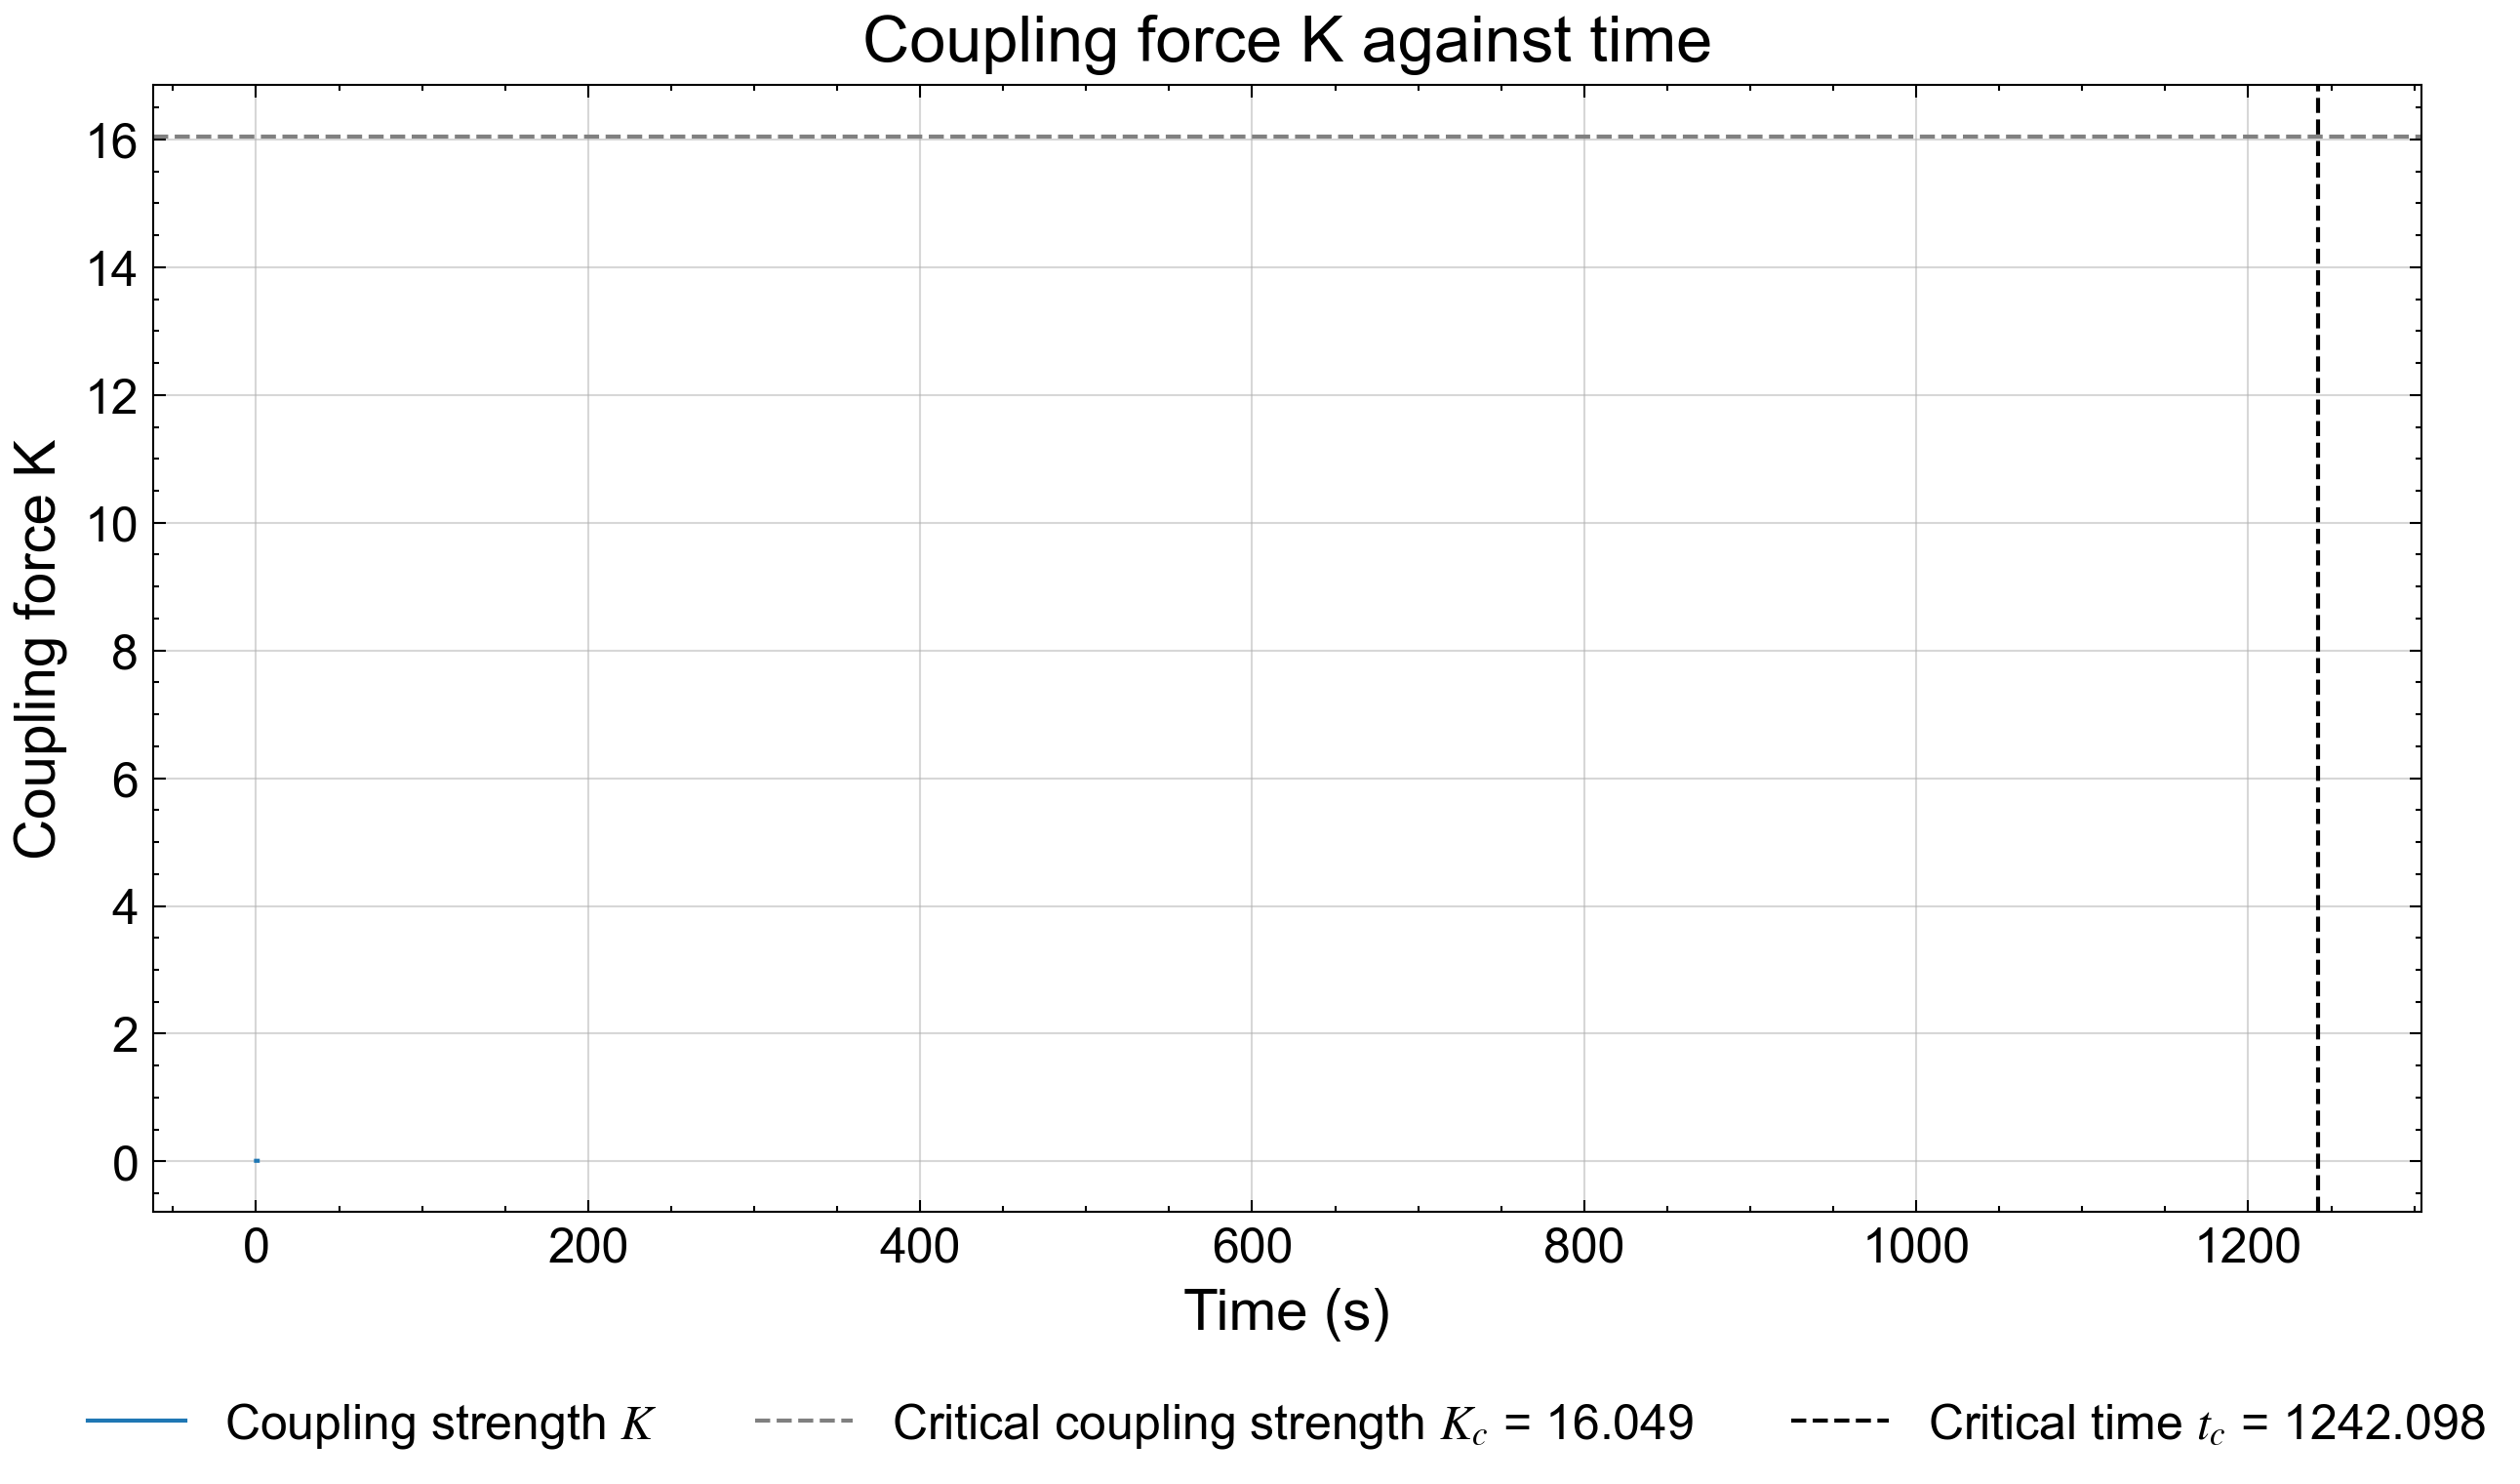

In [14]:
# Plotting K against t
plt.figure(figsize=(10,5), dpi=300)
plt.plot(t_eval, K(t_eval), color="tab:blue", label=r"Coupling strength $K$")
plt.axhline(y=K_c, color='grey', linestyle='--', linewidth=1, label=rf"Critical coupling strength $K_c$ = {K_c:.3f}")
plt.axvline(x=t_c, color='black', linestyle='--', linewidth=1, label=rf"Critical time $t_c$ = {t_c:.3f}")
plt.xlabel("Time (s)")
plt.ylabel("Coupling force K")
plt.title("Coupling force K against time")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.grid(alpha=0.5)
plt.show()

### Graph of Coupling Paramter r(t) against t

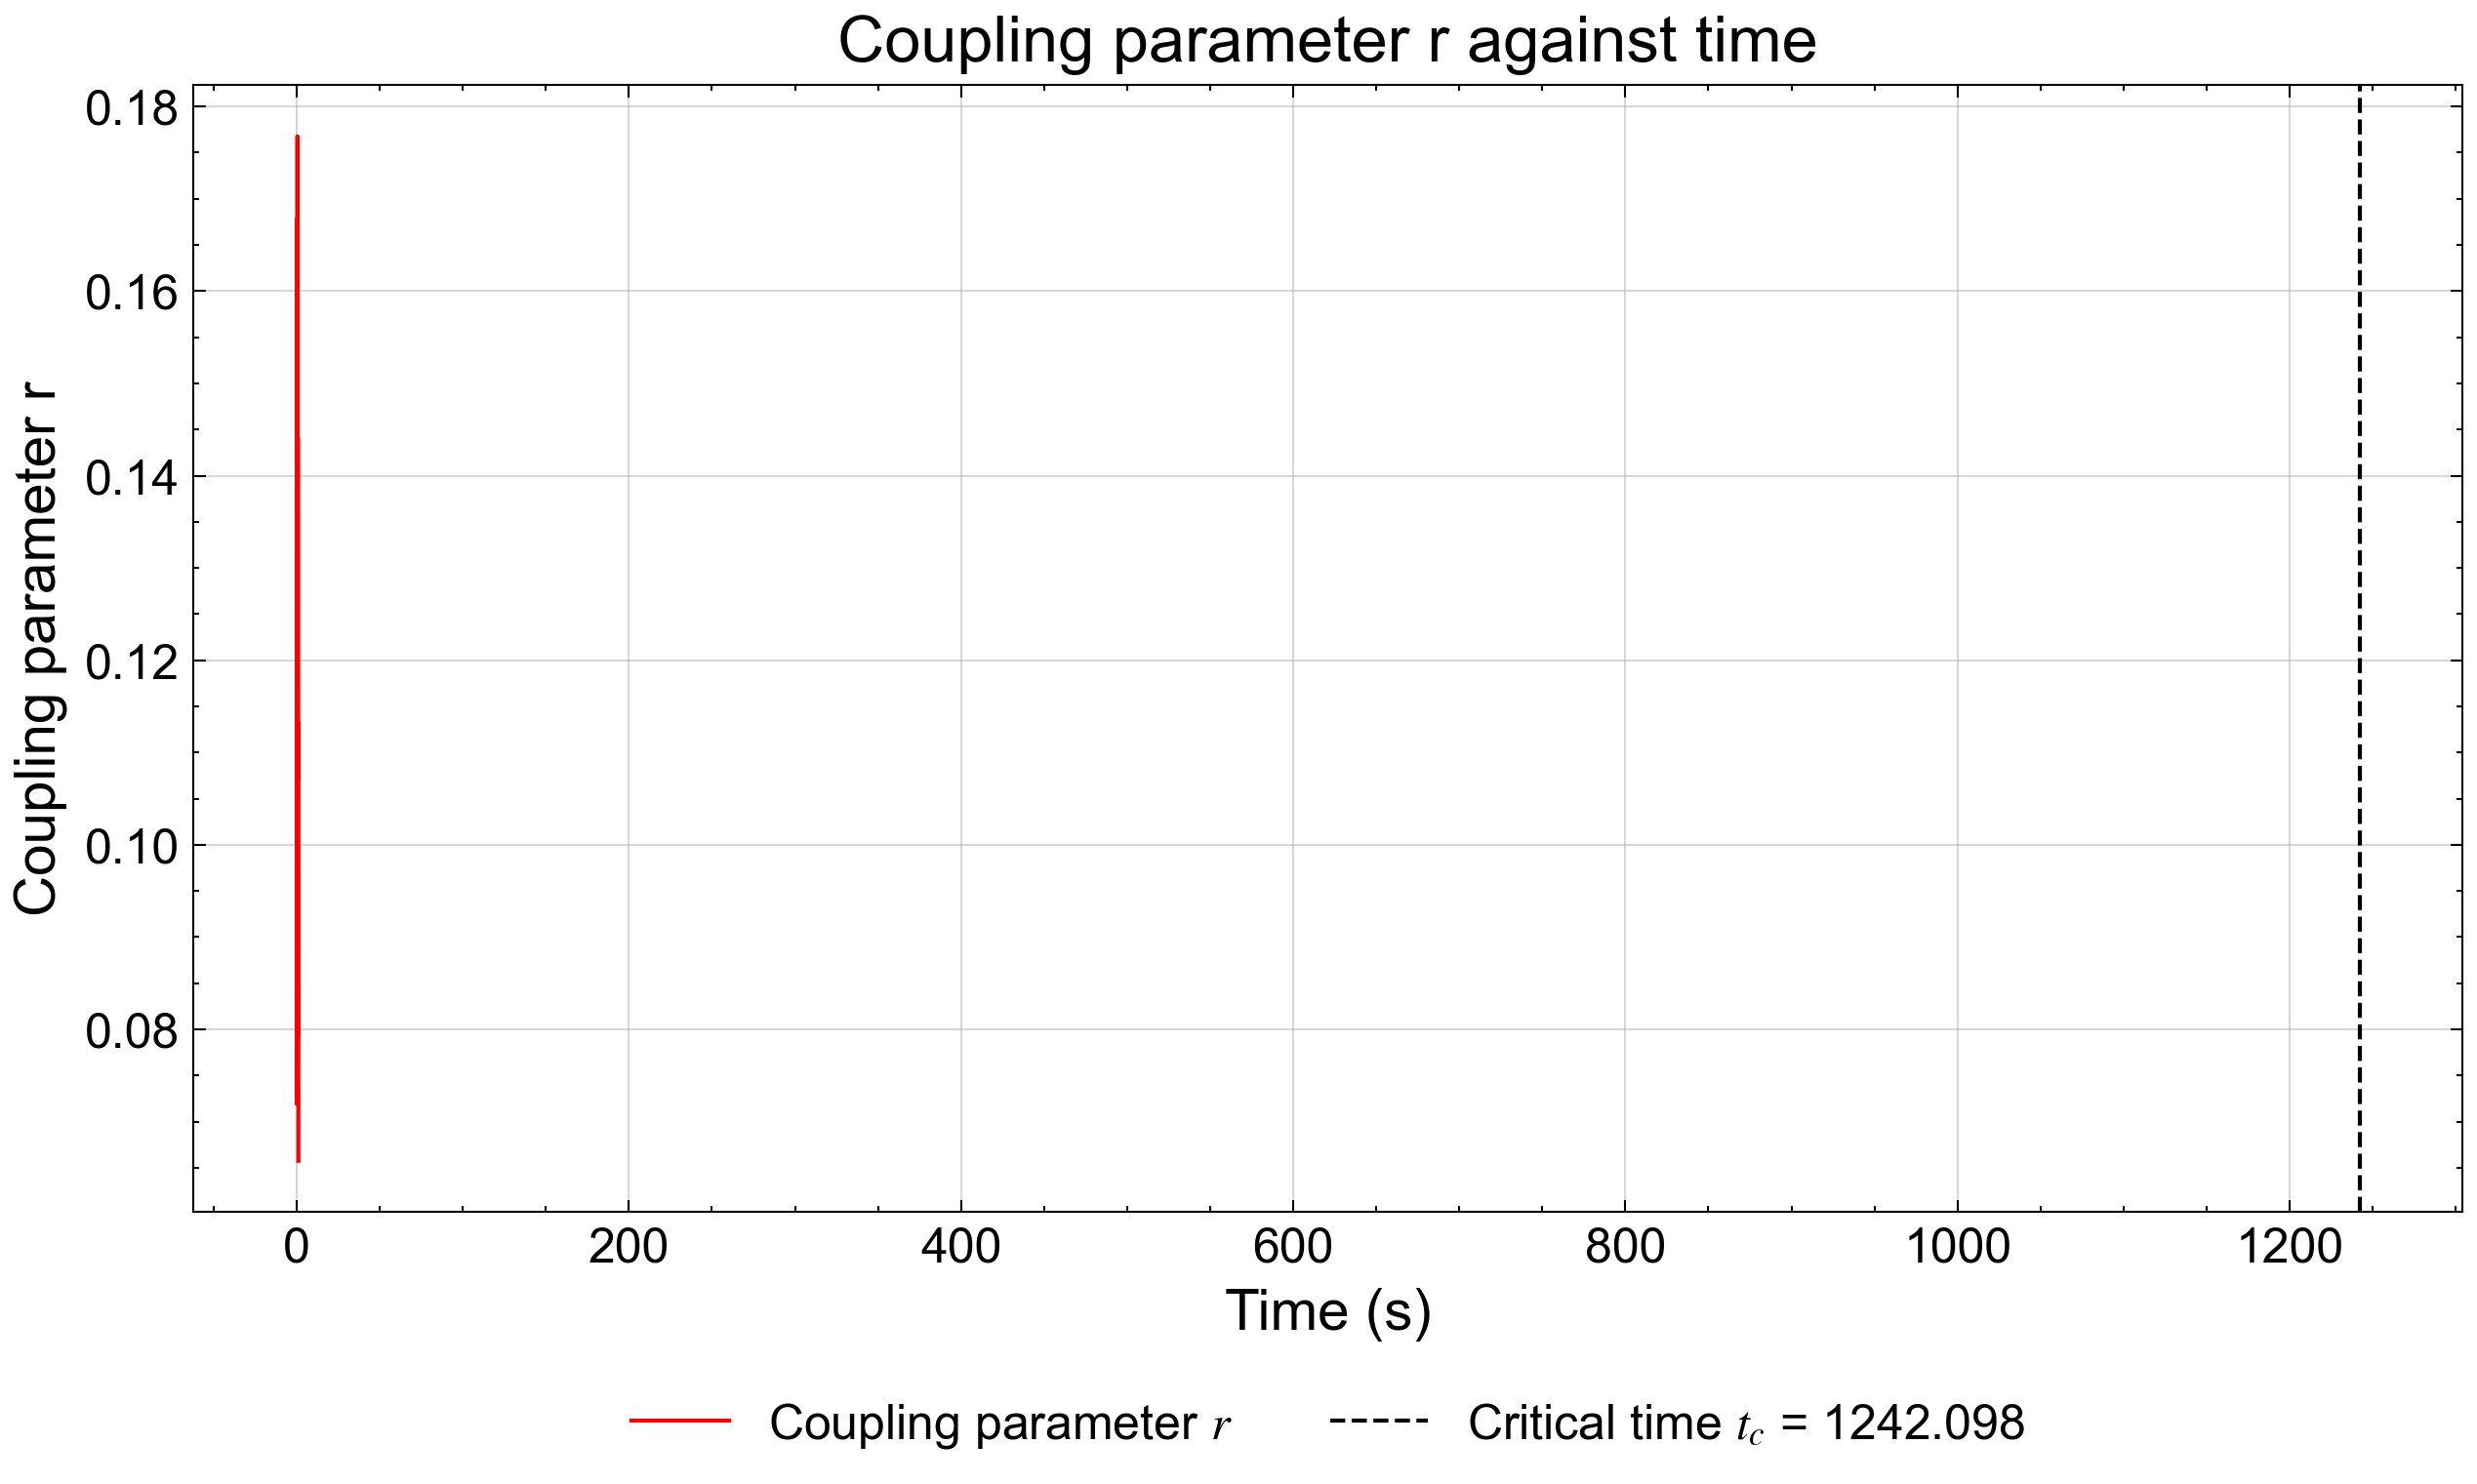

In [15]:
r = np.abs(np.mean(np.exp(1j*sol.y), axis=0))

plt.figure(figsize=(10,5), dpi=300)
plt.plot(sol.t, r, color="red", label=r"Coupling parameter $r$")
plt.axvline(x=t_c, color='black', linestyle='--', linewidth=1, label=rf"Critical time $t_c$ = {t_c:.3f}")
plt.xlabel("Time (s)")
plt.ylabel("Coupling parameter r")
plt.title("Coupling parameter r against time")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.grid(alpha=0.5)
plt.show()

### Defining and plotting reconstructed amplitude S(t) against time

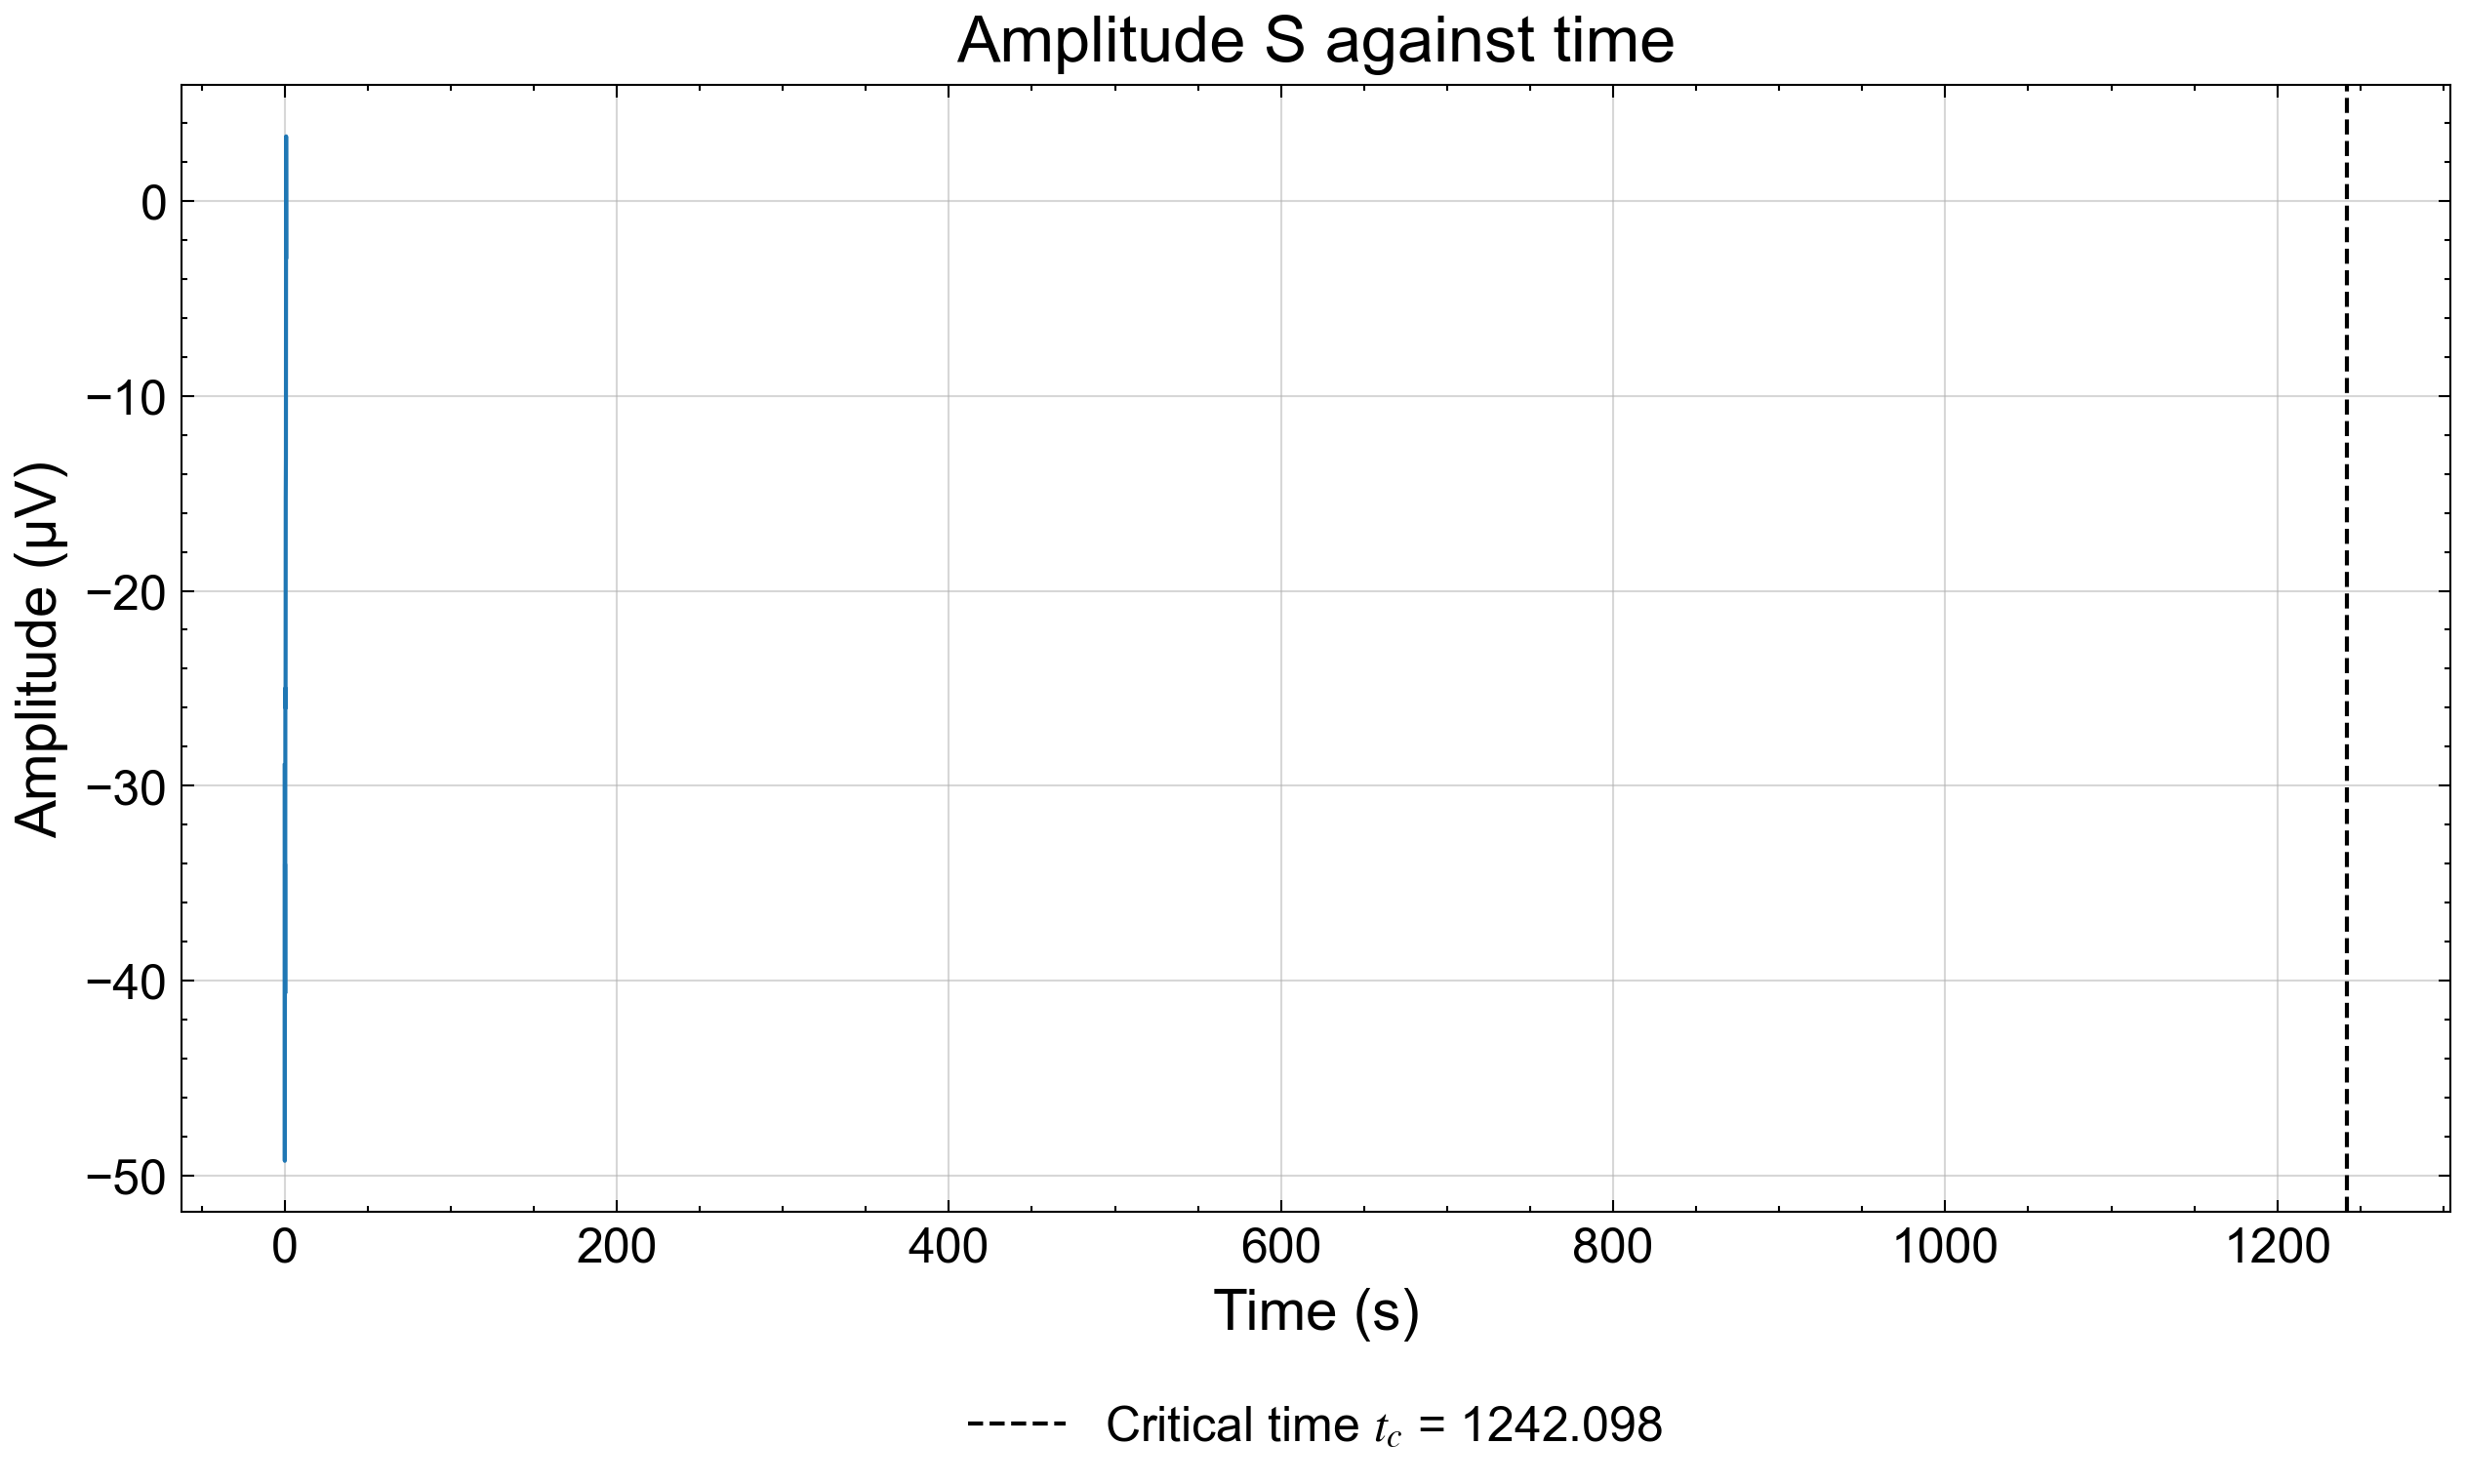

In [16]:
# Defining S(t)
S = A_0/2+2*np.sum(amp[:, None]*(np.cos(sol.y)), axis=0)

# Plotting S(t) against (t)
plt.figure(figsize=(10,5), dpi=300)
plt.plot(sol.t, S, color="tab:blue")
plt.axvline(x=t_c, color='black', linestyle='--', linewidth=1, label=rf"Critical time $t_c$ = {t_c:.3f}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.title("Amplitude S against time")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25))
plt.grid(alpha=0.5)
plt.show()

# Graph of original VS reconstructed signals against time

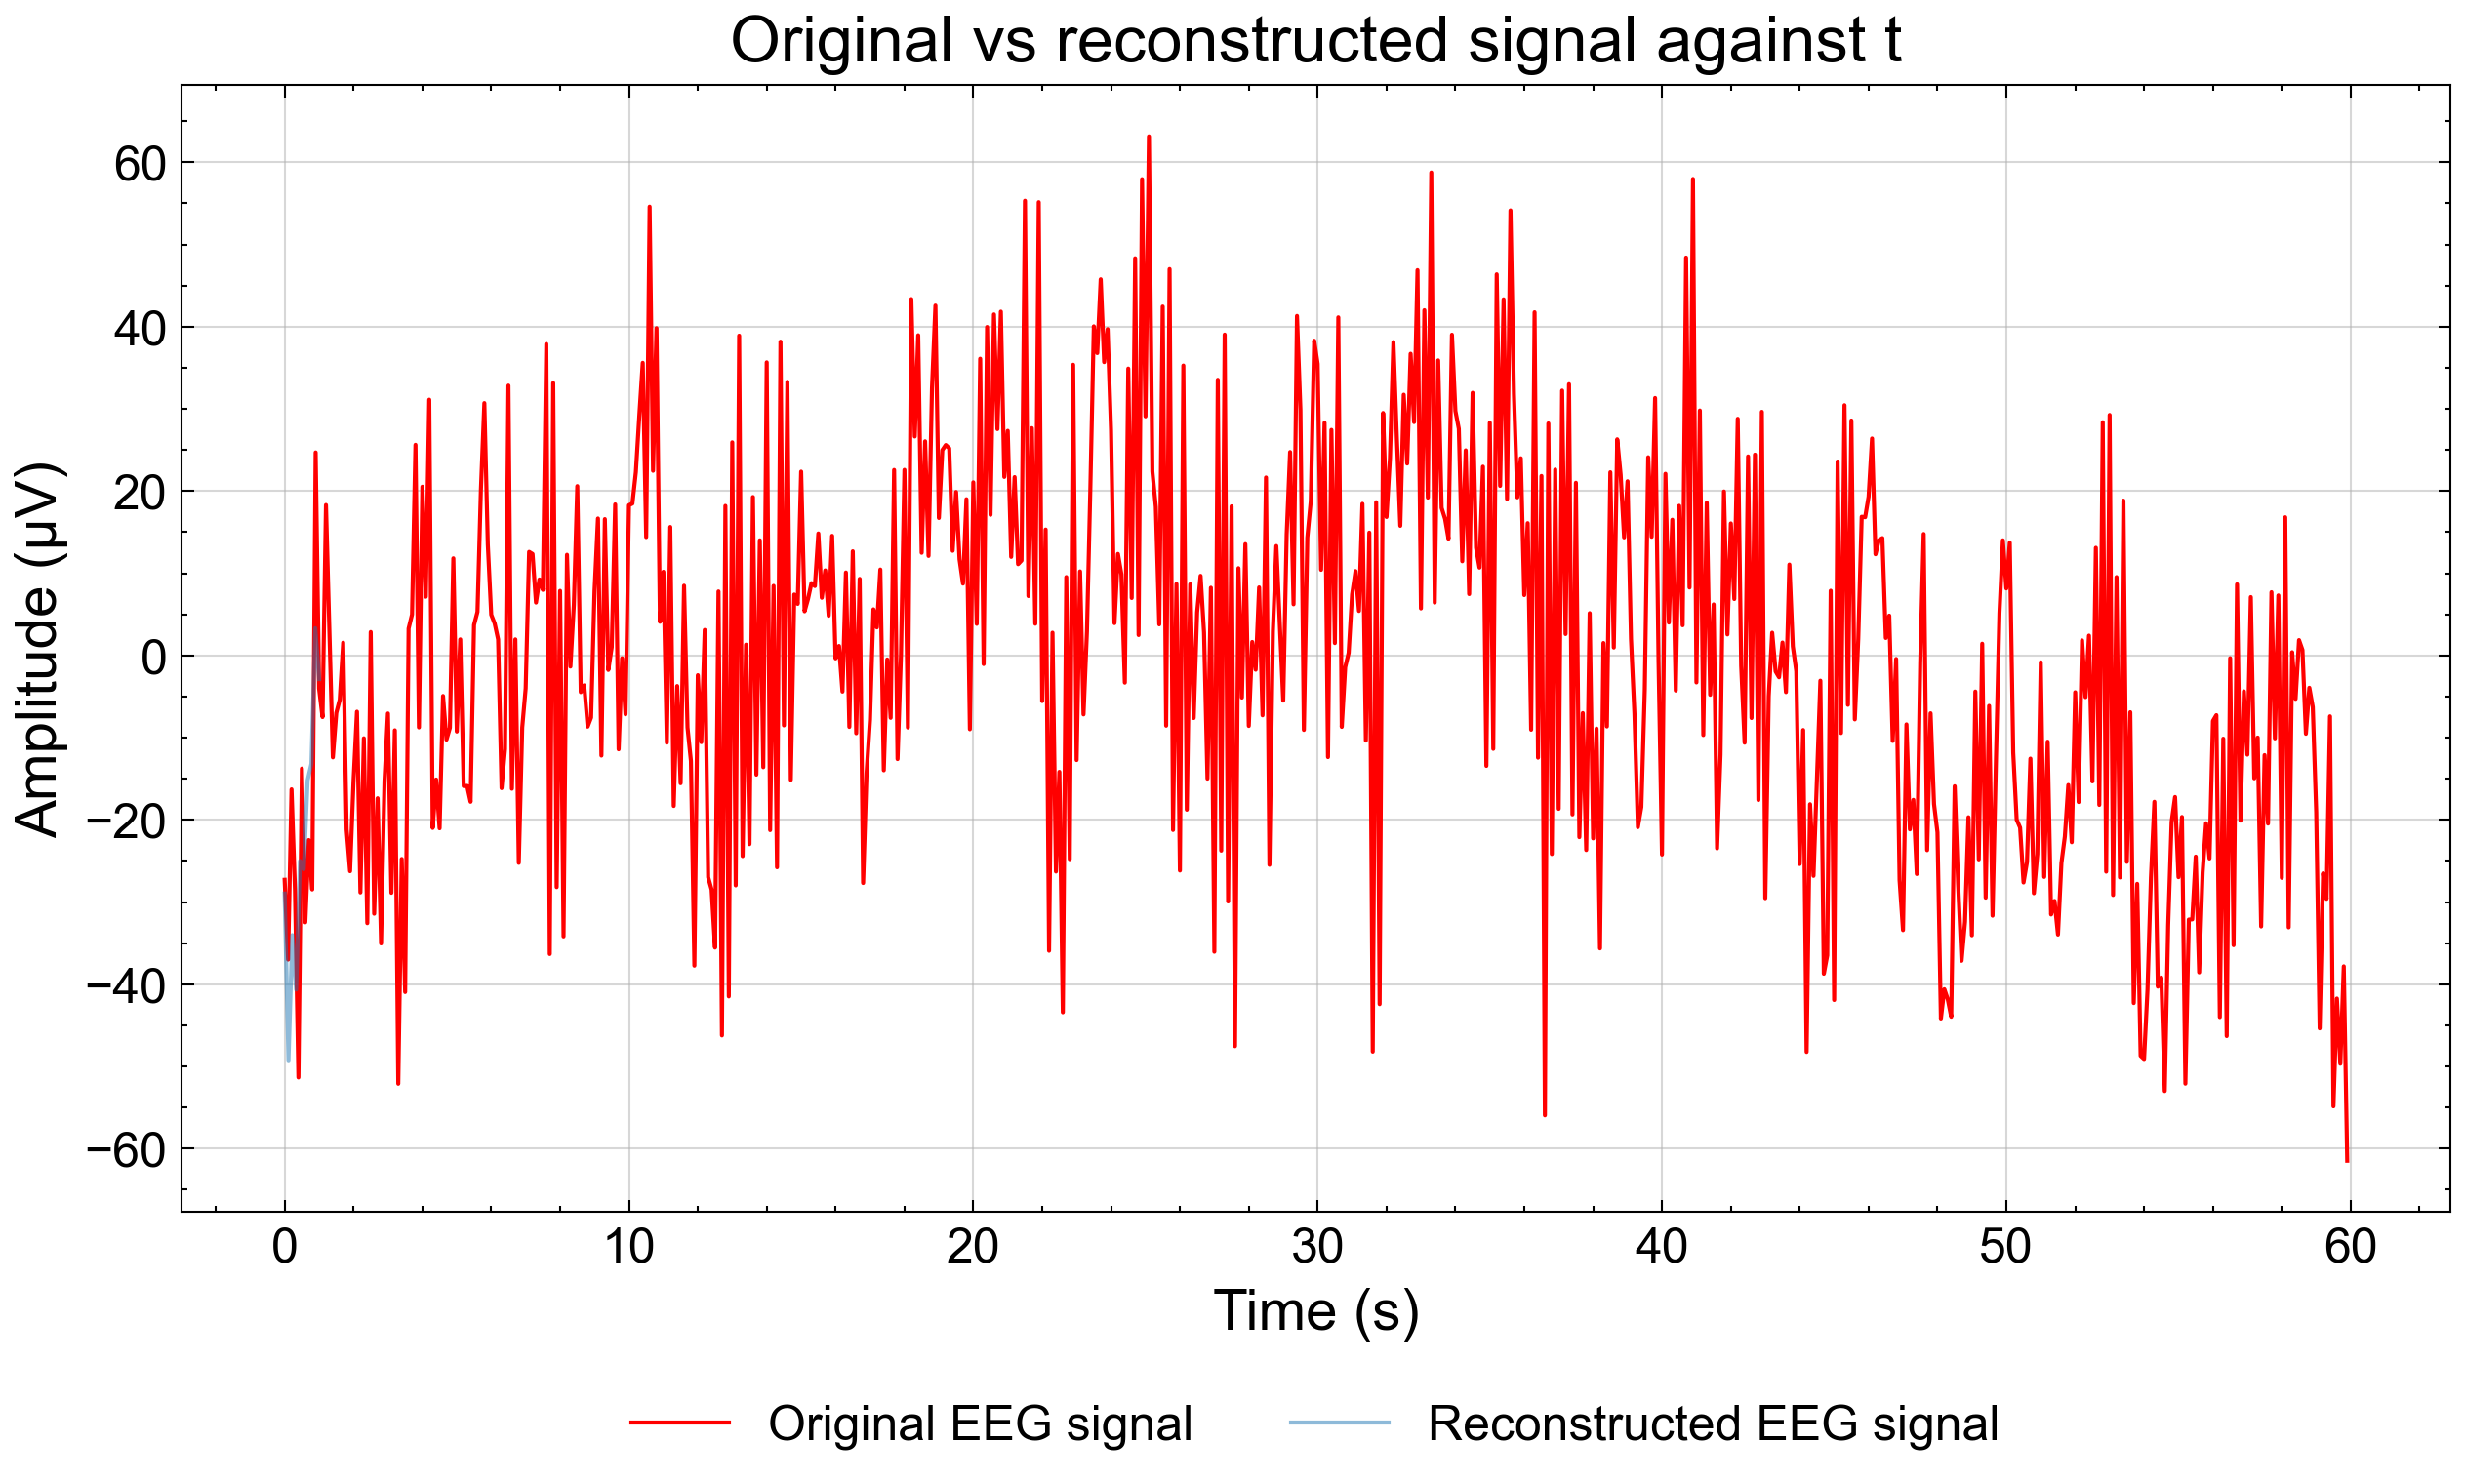

In [17]:
signal_length = len(data)/fs # in s
mask_signal = t_eval <= signal_length
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(t, data, color="red", label="Original EEG signal")
plt.plot(t_eval[mask_signal], S[mask_signal], alpha=0.5, color="tab:blue", label="Reconstructed EEG signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.title("Original vs reconstructed signal against t")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.grid(alpha=0.5)
plt.show()

## Animation of $r(t)$ and $\theta(t)$ against time

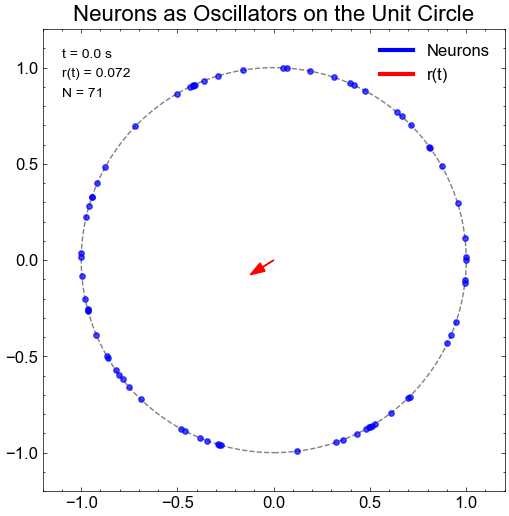

In [18]:

# Truncate solution up to t_c, ending at t_c + 300s 
mask = sol.t <= t_c + 300
t_anim = sol.t[mask][::20] # sampling every 5 t
theta_anim = sol.y[:, mask][:, ::20]
frames = len(t_anim)

# Set up animation figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.set_title("Neurons as Oscillators on the Unit Circle")

# Unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

# Neurons and r(t)
neuron_points = ax.scatter([], [], color='blue', s=15, alpha=0.7)
r_arrow = ax.arrow(0, 0, 0, 0, head_width=0.05, color='red')

# Legend
blue_proxy = plt.Line2D([0], [0], color='blue', lw=3, label='Neurons')
red_proxy = plt.Line2D([0], [0], color='red', lw=3, label='r(t)')
ax.legend(handles=[blue_proxy, red_proxy], loc='upper right')

# Text for time and r(t)
time_text = ax.text(-1.1, 1.05, '', fontsize=10)
r_text = ax.text(-1.1, 0.95, '', fontsize=10)
N_text = ax.text(-1.1, 0.85, '', fontsize=10)

# For fading red trail
trail_length = 20
trail_segments = [ax.plot([], [], color='red', alpha=0, lw=1)[0] for _ in range(trail_length)]

# Update function
def update(frame):
    global r_arrow
    
    theta = theta_anim[:, frame]
    # Update neuron phases
    x = np.cos(theta)
    y = np.sin(theta)
    neuron_points.set_offsets(np.c_[x, y])

    # Order parameter
    r_vec = np.mean(np.exp(1j * theta))
    r_mag, r_ang = np.abs(r_vec), np.angle(r_vec)

    # Remove r(t) arrow
    if r_arrow in ax.patches:
        r_arrow.remove()

    # Draw r(t) arrow (length = r_mag, tip on circle)
    r_arrow = ax.arrow(0, 0, 0.95*r_mag*np.cos(r_ang), 0.95*r_mag*np.sin(r_ang),
                       head_width=0.05, color='red')

    # Update fading trail for last 20 timesteps
    start = max(0, frame - trail_length)
    r_trail = np.array([np.mean(np.exp(1j * theta_anim[:, k])) for k in range(start, frame+1)])
    for i, seg in enumerate(trail_segments):
        if i < len(r_trail) - 1:
            seg.set_data(np.real(r_trail[i:i+2]), np.imag(r_trail[i:i+2]))
            seg.set_alpha((i + 1) / trail_length)  # progressively fade
        else:
            seg.set_alpha(0)  # hide unused segments

    # Update text
    time_text.set_text(f"t = {t_anim[frame]:.1f} s")
    r_text.set_text(f"r(t) = {r_mag:.3f}")
    N_text.set_text(f"N = {N}")

    return [neuron_points, r_arrow, time_text, r_text, N_text] + trail_segments

# --- Animation setup ---
ani = FuncAnimation(fig, update, frames=frames, interval=50, blit=True)

## Save animation as MP4

In [19]:
ani.save(r"C:\Users\taser\Downloads\kuramoto_animation.mp4", writer="ffmpeg", fps=30, dpi=200)

MovieWriter ffmpeg unavailable; using Pillow instead.


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\taser\\Downloads'